In [1]:
import torch
from torch import nn, optim
import matplotlib.pyplot as plt

In [2]:
n_choices = 100

In [3]:
rewards = torch.randn(n_choices)
rewards

tensor([ 0.2728,  0.8485,  1.9570,  0.3642, -0.0509,  0.6485,  0.7558, -0.0512,
        -0.6041,  0.2835, -1.2313,  0.4070,  1.6300, -0.1443, -0.0804, -0.1053,
        -2.1896,  1.3278,  0.7259,  0.5541,  0.4484, -1.1840, -0.9875,  0.1828,
         0.9440,  0.0799,  0.2153, -0.2423,  0.3681,  0.4124, -0.1718,  0.8834,
         0.0794, -0.6686, -0.5554, -0.0388, -0.3344,  0.8385, -0.7370,  0.9448,
         1.4550,  1.5817,  1.8372,  1.0672,  0.6631, -1.6958,  2.3548,  1.7494,
        -1.2317,  0.0795, -1.2483, -0.3615,  1.7780,  1.3128,  0.7940,  0.3622,
        -1.7430, -1.0513,  0.4906,  1.0958, -1.4606,  1.7415,  0.1645, -0.8946,
         1.0477, -0.1584,  0.4664, -0.2181,  0.5473,  0.3880,  1.0698,  1.2805,
        -0.0783, -0.7171,  0.0632, -1.1582, -0.1649, -0.4684,  0.6221,  0.2257,
        -0.3597, -0.7624, -1.0163, -0.4416, -0.0059, -0.3830,  0.2634, -1.2830,
         1.1535,  1.4681, -1.8486, -1.0262, -0.8522, -1.7145, -1.4729, -0.4306,
         2.1838,  1.2451, -0.6267, -0.39

In [4]:
class Actor(nn.Module):
    def __init__(self, n_out, n_hidden=10):
        super().__init__()
        self.x = torch.ones(1)
        self.layers = nn.Sequential(
            nn.Linear(1, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_out),
            nn.Softmax(-1)
        )

    def forward(self):
        return self.layers(self.x)

In [5]:
class Critic(nn.Module):
    def __init__(self, n_in, n_hidden=10):
        super().__init__()
        self.x = torch.ones(n_hidden)
        self.layers = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [6]:
class Sampler:
    def __init__(self, weights):
        self.sampler = torch.distributions.categorical.Categorical(weights)
        
    def sample(self, n=1):
        return  self.sampler.sample((n,))

In [7]:
class OneHotEncoder:
    def __init__(self, n):
        self.n = n
        
    def encode(self, x):
        return nn.functional.one_hot(x, self.n)

In [8]:
actor = Actor(n_choices)
critic = Critic(n_choices)

In [9]:
encoder = OneHotEncoder(n_choices)

In [10]:
actor_optimizer = optim.Adam(actor.parameters(), lr=0.001)
critic_optimizer = optim.Adam(critic.parameters(), lr=0.005)

In [11]:
criterion = nn.MSELoss()

In [12]:
epochs = 1000
actor_iters = 10000
critic_iters = 10

In [13]:
critic_losses = []
actor_rewards = []

for _ in range(epochs):
    critic_optimizer.zero_grad()
    choice = Sampler(actor()).sample(critic_iters)
    x = encoder.encode(choice)
    pred_reward = critic(x.float())
    real_reward = rewards[choice].unsqueeze(-1)
    loss = criterion(pred_reward, real_reward)
    loss.backward()
    critic_optimizer.step()
    
    critic_losses.append(loss.item())
    
    actor_optimizer.zero_grad()
    probs = actor()
    choice = Sampler(probs).sample(actor_iters)
    x = encoder.encode(choice)
    reward = critic(x.float())
    loss = -(reward * torch.log(probs[choice].unsqueeze(-1))).mean()
    loss.backward()
    actor_optimizer.step()
    
    actor_rewards.append(reward.mean().item())

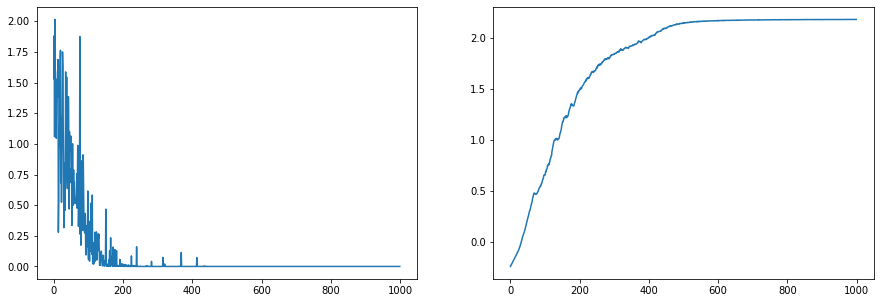

In [14]:
_, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(critic_losses)
axs[1].plot(actor_rewards)

<BarContainer object of 100 artists>

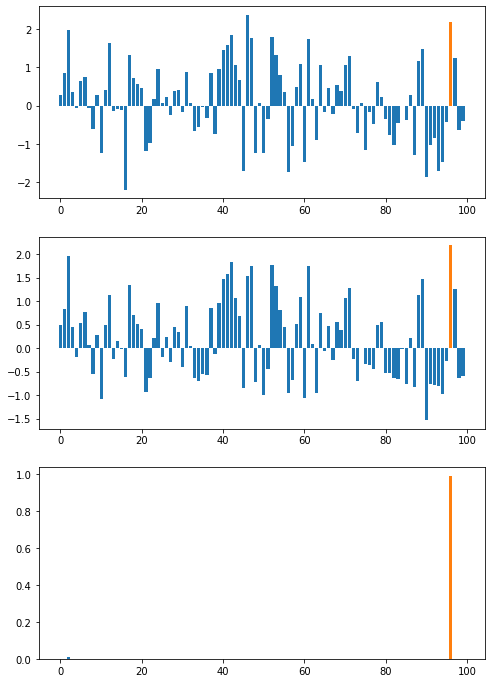

In [15]:
color=['C1' if i == actor().argmax() else 'C0' for i in range(n_choices)]
_, axs = plt.subplots(3, 1, figsize=(8, 12))
axs[0].bar(range(n_choices), rewards, color=color)
axs[1].bar(range(n_choices), critic(encoder.encode(torch.arange(n_choices)).float()).flatten().detach().numpy(), color=color)
axs[2].bar(range(n_choices), actor().detach().numpy(), color=color)